# Project: Image Classification and Regression - Marion Favre d'Echallens

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.patches as patches
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten

Using TensorFlow backend.


In [3]:
#Keras modules
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation

Useful functions and example

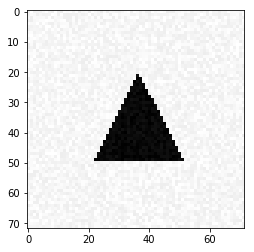

In [4]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


#### 3) SIMPLE CLASSIFICATION: RECTANGLE(0), DISK(1), TRIANGLE(2)

##### a) STOCHASTIC GRADIENT OPTIMIZER

In [5]:
[X_train, Y_train] = generate_dataset_classification(300, 20) 
# Convert labels to categorical one-hot encoding
Y_train = np_utils.to_categorical(Y_train, num_classes=3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [12]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(168, activation='relu', input_shape=(5184,)))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 3.3222 - acc: 0.3533
Epoch 2/10
300/300 [==============================] - 0s 493us/step - loss: 1.0190 - acc: 0.4967
Epoch 3/10
300/300 [==============================] - 0s 476us/step - loss: 0.8321 - acc: 0.7133
Epoch 4/10
300/300 [==============================] - 0s 443us/step - loss: 0.7959 - acc: 0.6167
Epoch 5/10
300/300 [==============================] - 0s 463us/step - loss: 1.1227 - acc: 0.5067
Epoch 6/10
300/300 [==============================] - 0s 516us/step - loss: 0.8482 - acc: 0.6267
Epoch 7/10
300/300 [==============================] - 0s 506us/step - loss: 0.6615 - acc: 0.6800
Epoch 8/10
300/300 [==============================] - 0s 806us/step - loss: 0.5435 - acc: 0.7400
Epoch 9/10
300/300 [==============================] - 0s 623us/step - loss: 1.5930 - acc: 0.5133
Epoch 10/10
300/300 [==============================] - 0s 576us/step - loss: 0.6209 - acc: 0.7367


In [13]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test,batch_size=32, verbose=0)

array([[1.9537338e-23, 1.0000000e+00, 0.0000000e+00]], dtype=float32)

##### B) ADAM OPTIMIZER

In [8]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)


Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 2.2875 - acc: 0.4233
Epoch 2/10
300/300 [==============================] - 0s 696us/step - loss: 1.3426 - acc: 0.4133
Epoch 3/10
300/300 [==============================] - 0s 486us/step - loss: 0.6967 - acc: 0.6033
Epoch 4/10
300/300 [==============================] - 0s 386us/step - loss: 0.5701 - acc: 0.7600
Epoch 5/10
300/300 [==============================] - 0s 363us/step - loss: 0.5121 - acc: 0.7267
Epoch 6/10
300/300 [==============================] - 0s 346us/step - loss: 0.3613 - acc: 0.8467
Epoch 7/10
300/300 [==============================] - 0s 463us/step - loss: 0.2818 - acc: 0.9567
Epoch 8/10
300/300 [==============================] - 0s 576us/step - loss: 0.2597 - acc: 0.9467
Epoch 9/10
300/300 [==============================] - 0s 983us/step - loss: 0.2365 - acc: 0.9467
Epoch 10/10
300/300 [==============================] - 0s 370us/step - loss: 0.2116 - acc: 0.9433


In [9]:
#testing
X_test = generate_a_disk() #classe 1
X_test = X_test.reshape(1, X_test.shape[0])
model_A.predict(X_test,batch_size=32, verbose=0)

array([[0., 1., 0.]], dtype=float32)

### 4) VISUALIZATION OF THE SOLUTION

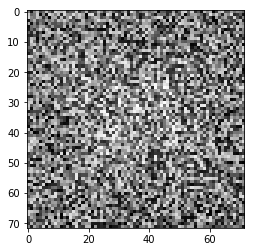

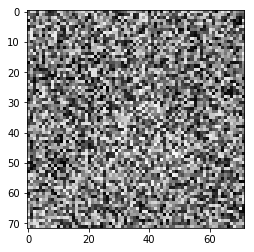

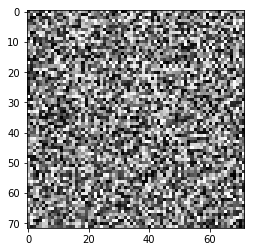

In [14]:
# SGD optimizer
W = model.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

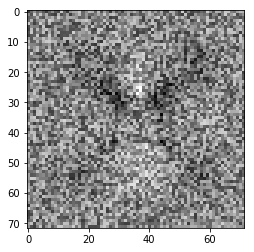

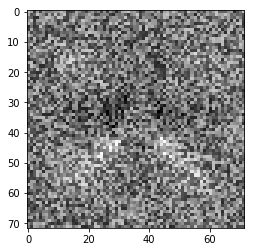

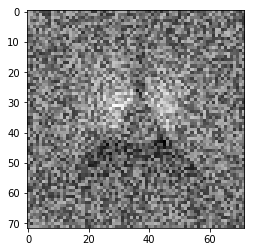

In [11]:
# Adam optimizer
W = model_A.layers[0].get_weights()
plt.imshow(W[0][:,0].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,1].reshape(72,72), cmap='gray')
plt.show()
plt.imshow(W[0][:,2].reshape(72,72), cmap='gray')
plt.show()

### 5) MORE DIFFICULT CLASSIFICATION PROBLEM

In [15]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = np_utils.to_categorical(Y_train, num_classes=3)


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [16]:
#Stochastic Gradient Descent 
# For a three-class classification problem
model = Sequential()
model.add(Dense(168, activation='relu', input_dim=5184))
model.add(Dense(3, activation='softmax'))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,metrics=['accuracy']) 

#training the model  
model.fit(X_train, Y_train, epochs=10, batch_size=64)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 7.2800 - acc: 0.3700
Epoch 2/10
300/300 [==============================] - 0s 463us/step - loss: 10.8529 - acc: 0.3267
Epoch 3/10
300/300 [==============================] - 0s 446us/step - loss: 10.8529 - acc: 0.3267
Epoch 4/10
300/300 [==============================] - 0s 590us/step - loss: 10.8529 - acc: 0.3267
Epoch 5/10
300/300 [==============================] - 0s 470us/step - loss: 10.8529 - acc: 0.3267
Epoch 6/10
300/300 [==============================] - 0s 463us/step - loss: 10.8529 - acc: 0.3267
Epoch 7/10
300/300 [==============================] - 0s 733us/step - loss: 10.8529 - acc: 0.3267
Epoch 8/10
300/300 [==============================] - 0s 796us/step - loss: 10.8529 - acc: 0.3267
Epoch 9/10
300/300 [==============================] - 0s 566us/step - loss: 10.8529 - acc: 0.3267
Epoch 10/10
300/300 [==============================] - 0s 583us/step - loss: 10.8529 - acc: 0.3267


In [17]:
[X_test, Y_test] = generate_test_set_classification()

model.evaluate(X_test, Y_test) #SGD optimizer

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 610us/step


[10.799123980204264, 0.3299999996026357]

In [18]:
# For a three-class classification problem
model_A = Sequential()
model_A.add(Dense(3, activation='softmax',input_shape = (5184,)))
model_A.compile(loss='categorical_crossentropy', 
              optimizer='adam',metrics=['accuracy']) 
#training the model
model_A.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 1.9161 - acc: 0.3300
Epoch 2/10
300/300 [==============================] - 0s 703us/step - loss: 1.2615 - acc: 0.4167
Epoch 3/10
300/300 [==============================] - 0s 440us/step - loss: 1.1021 - acc: 0.4700
Epoch 4/10
300/300 [==============================] - 0s 333us/step - loss: 1.0162 - acc: 0.5333
Epoch 5/10
300/300 [==============================] - 0s 346us/step - loss: 0.9156 - acc: 0.5133
Epoch 6/10
300/300 [==============================] - 0s 283us/step - loss: 0.8803 - acc: 0.5467
Epoch 7/10
300/300 [==============================] - 0s 396us/step - loss: 0.8060 - acc: 0.6167
Epoch 8/10
300/300 [==============================] - 0s 273us/step - loss: 0.7672 - acc: 0.6833
Epoch 9/10
300/300 [==============================] - 0s 287us/step - loss: 0.8400 - acc: 0.6067
Epoch 10/10
300/300 [==============================] - 0s 480us/step - loss: 0.7848 - acc: 0.6033


In [19]:
model_A.evaluate(X_test, Y_test) #Adam optimizer

300/300 [==============================] - 0s 729us/step


[0.9309525537490845, 0.5166666674613952]

Previous models are less efficient with the new training set.

In [26]:
#creating a new model  
X_train=X_train.reshape(X_train.shape[0],72,72,1)
print(X_train.shape)
Y_train=np_utils.to_categorical(Y_train,3)
print(Y_train.shape)

(300, 72, 72, 1)
(300, 72, 72, 3, 3)


In [24]:
##Convolution1D
model2 = Sequential() 
model2.add(Conv2D(16, (5,5), activation='relu',input_shape=(72,72,1))) 
model2.add(Dropout(0.5))
print(model2.output_shape)

model2.add(MaxPooling2D(pool_size =(2,2)))
model2.add(Flatten())
model2.add(Dense(3,activation='softmax'))
print(model2.output_shape)

#model.add(Dense(3, activation='relu')) 

model2.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])
model2.fit(X_train, Y_train, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 3)


ValueError: Error when checking target: expected dense_10 to have 2 dimensions, but got array with shape (300, 72, 72, 1)

In [26]:
model2.evaluate(X_test, Y_test)

NameError: name 'model2' is not defined

### 6) A REGRESSION PROBLEM

In [27]:
#normalize vertices
def normer(Y):
    for i in range(len(Y)):
        a = math.sqrt(Y[i,0]**2 + Y[i,1]**2)
        b = math.sqrt(Y[i,2]**2 + Y[i,3]**2)
        c = math.sqrt(Y[i,4]**2 + Y[i,5]**2)
        Y[i,:]=[Y[i,0]/a,Y[i,1]/a,Y[i,2]/b,Y[i,3]/b,Y[i,4]/c,Y[i,5]/c]
    return Y


Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


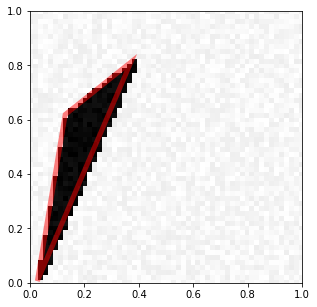

In [28]:
[X_train, Y_train] = generate_dataset_regression(300, 20)
visualize_prediction(X_train[0], Y_train[0])

In [35]:
Y_train = normer(Y_train)

model_r = Sequential()
model_r.add(Dense(168, activation='relu', input_shape=(5184,)))
model_r.add(Dense(6, activation='softmax'))
model_r.compile(optimizer='rmsprop',
              loss='mse',metrics=['accuracy']) 
    #training the model  


model_r.fit(X_train, Y_train, epochs=10, batch_size=64)


Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 0.4202 - acc: 0.1733
Epoch 2/10
300/300 [==============================] - 0s 503us/step - loss: 0.4484 - acc: 0.1933
Epoch 3/10
300/300 [==============================] - 0s 510us/step - loss: 0.4484 - acc: 0.1933
Epoch 4/10
300/300 [==============================] - 0s 693us/step - loss: 0.4484 - acc: 0.1933
Epoch 5/10
300/300 [==============================] - 0s 610us/step - loss: 0.4484 - acc: 0.1933
Epoch 6/10
300/300 [==============================] - 0s 506us/step - loss: 0.4484 - acc: 0.1933
Epoch 7/10
300/300 [==============================] - 0s 536us/step - loss: 0.4484 - acc: 0.1933
Epoch 8/10
300/300 [==============================] - 0s 523us/step - loss: 0.4484 - acc: 0.1933
Epoch 9/10
300/300 [==============================] - 0s 556us/step - loss: 0.4484 - acc: 0.1933
Epoch 10/10
300/300 [==============================] - 0s 513us/step - loss: 0.4484 - acc: 0.1933


In [22]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [26]:
Y_test = normer(Y_test)
model_r.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 663us/step


[0.4457277504603068, 0.13000000019868216]

### 7) IMAGE DENOISING